CRITERIA:

1. Compute the value analytically (1 point)

2. Compute the integral using trapezoidal rule (1 point)

3. Parallelize using MPI. You should be able to choose any number of MPI processes regardless of the number of discretization points. (2 points)

4. Plot the speedup vs number of processors (1 point)

5. Plot integration error vs the discretization size (1 point)

Take some function R -> R and compute its integral over some segment.

In [ ]:
import numpy as np
def f(x):
  return np.cos(x)
def I_an(x_0,x_1):
  return np.sin(x_1)-np.sin(x_0)

trapezoidal rule: $\int_a^bf(x)dx \approx (b-a)\cdot \dfrac{1}{2} \cdot (f(a)+f(b))$

In [ ]:
# analytical
print(I_an(0,np.pi/2))

1.0


In [ ]:
#numerical
x_array = np.linspace(0,np.pi/2,10000)
x_step = x_array[1]-x_array[0]
f_array = np.empty( len(x_array) - 1)
f_array = 0.5*x_step*(f(x_array[:-1])+f(x_array[1:]) )
I_num=sum(f_array)
print(f"numerical result = {I_num}")
print(f"error is {abs(I_an(0,np.pi/2)-I_num)}")

numerical result = 0.9999999979434216
error is 2.056578352060967e-09


In [ ]:
pip install mpi4py

In [ ]:
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%%writefile parallel_integral.py
import numpy as np
from mpi4py import MPI
import sys
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

a, b, n = 1*np.pi, 2*np.pi, 10000
if len(sys.argv) == 4:
  a = float( sys.argv[1] ) *np.pi
  b = float( sys.argv[2] ) *np.pi
  n = int  ( sys.argv[3] )

def f(x):
  return np.cos(x)
def I_an(x_0,x_1):
  return np.sin(x_1)-np.sin(x_0)

x_array = np.linspace(a,b,n)
x_step = x_array[1]-x_array[0]

x_array = np.array_split(x_array,size)[rank]
if rank != size-1:
  x_array = np.append(x_array,x_array[-1]+x_step)

f_array = np.empty( len(x_array) - 1)
#trapeziodal rule
# for i in range(len(x_array)-1)
f_array = 0.5*x_step*(f(x_array[:-1])+f(x_array[1:]) )
I_partial=sum(f_array)

I_num = comm.reduce(I_partial,op=MPI.SUM,root=0)
# if rank == 0:
#   print(f"numerical result = {I_num}")
#   print(f"analitical result is {I_an(a,b)}")
#   print("error is {:.3e}".format(abs(I_an(a,b)-I_num)))


Overwriting parallel_integral.py


In [ ]:
!mpiexec -n 3 --allow-run-as-root python -m mpi4py parallel_integral.py 0 0.5 10000

numerical result = 0.9999999979434224
analitical result is 1.0
error is 2.057e-09


In [ ]:
import time

In [ ]:
T = []
for i in range(1,11):
    t_start = time.time()
    !mpirun -n {i} --allow-run-as-root python -m mpi4py parallel_integral.py 0 0.5 100000
    t_end = time.time()
    T.append(t_end-t_start)
    print('---Time: {:6.3f}     Processes: {}---\n \n'.format(T[-1],i))

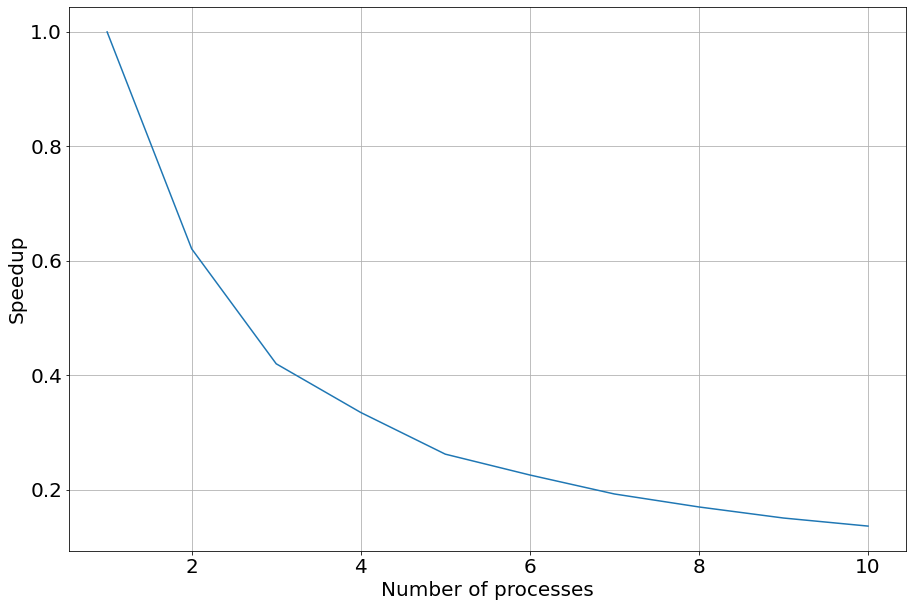

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(range(1,11), [T[0]/i for i in T])
plt.xlabel('Number of processes', fontsize=20)
plt.ylabel('Speedup', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid();

In [ ]:
%%writefile parallel_integral_err.py
import numpy as np
from mpi4py import MPI
import sys
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

a, b, N = 0*np.pi, 0.5*np.pi, [10**i for i in range(1,9)]
# if len(sys.argv) == 4:
#   a = float( sys.argv[1] ) *np.pi
#   b = float( sys.argv[2] ) *np.pi
#   n = int  ( sys.argv[3] )
I_partial = np.zeros(len(N))
I_num = np.zeros(len(N))
I_err=np.zeros(len(N))

def f(x):
  return np.cos(x)
def I_an(x_0,x_1):
  return np.sin(x_1)-np.sin(x_0)

count=0
for n in N:
  x_array = np.linspace(a,b,n)
  x_step = x_array[1]-x_array[0]

  x_array = np.array_split(x_array,size)[rank]
  if rank != size-1:
    x_array = np.append(x_array,x_array[-1]+x_step)

  f_array = np.empty( len(x_array) - 1)
  #trapeziodal rule
  # for i in range(len(x_array)-1)
  f_array = 0.5*x_step*(f(x_array[:-1])+f(x_array[1:]) )
  
  I_partial[count]=sum(f_array)
  I_num[count] = comm.reduce(I_partial[count],op=MPI.SUM,root=0)
  I_err[count] = abs(I_an(a,b)-I_num[count])

  
  # if rank == 0:
  #   print(f"n = {n}")
  #   print(f"numerical result = {I_num[count]}")
  #   print(f"analitical result is {I_an(a,b)}")
  #   print("error is {:.3e}".format(abs(I_an(a,b)-I_num[count])))
  count+=1
  

if rank == 0:
  plt.figure(figsize=(15,10))
  plt.plot(N,I_err)
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('Discritization', fontsize=20)
  plt.ylabel('Integration error', fontsize=20)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.grid();  
  plt.savefig("error_vs_discritisation.png")


In [ ]:
!mpiexec -n 1 --allow-run-as-root python -m mpi4py parallel_integral_err.py

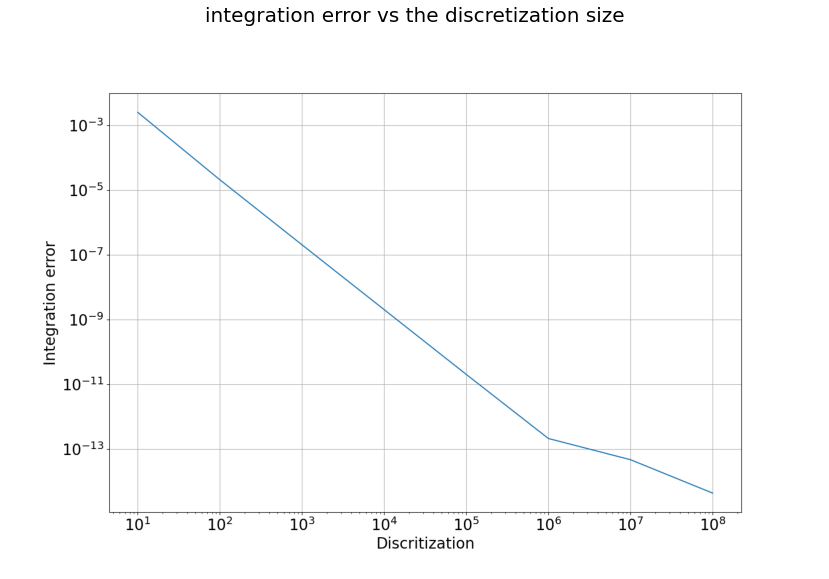

In [ ]:
# %pylab inline
import matplotlib.image as mpimg
img = mpimg.imread('error_vs_discritisation.png')
plt.figure(figsize=(15,10))
imgplot = plt.imshow(img)
plt.title("integration error vs the discretization size",fontsize=20)
plt.axis('off')
plt.show()
